In [7]:
import numpy as np
import random
from matplotlib import pyplot as plt
from keras.datasets import fashion_mnist
from tqdm import tqdm_notebook as tqdm
import math
import cv2 as cv

In [1]:
class PreProc:
    '''Class used for preprocessing all images. 
        making a constructor of this class immediately loads in desired dataset
        
        visualize(n) logs into wandb 10 images each belonging to a separate class.
        
        flattenAndCentralize() makes the mean of the image arrays 0. This helps increasing the 
        training accuracy quicker per epoch
        
        getLabels() return labels in corresponding index fashion
        
        getInputsize returns the number of images present in the training sample
    '''
    def __init__(self):
        (self.trainx,self.trainy),(self.testx, self.testy) = fashion_mnist.load_data()
        
    def visualize(self,n):
        ''' args -> n :: The number of images desired to be visualized
            returns-> null
            
            shows the images via matplotlib
        '''
        for i in range(n):
            plt.subplot(330+1+i) # ask someone why??
            plt.imshow(self.trainx[i], cmap = plt.get_cmap('gray'))
        plt.show()
            
        
    def flattenAndCentralize(self):
        ''' args -> none
            returns -> trainx_flattened :: The training images, mean centered and flattened
                        into a 1 dimensional array
                    -> testx_flattened :: The testing images, mean centered and flattened
                        into a 1 dimensional array
        '''
        trainx_flattened = np.copy(self.trainx).astype('float64')
        testx_flattened = np.copy(self.testx).astype('float64')
        trainx_flattened -= np.mean(trainx_flattened, axis = 0)
        testx_flattened -= np.mean(testx_flattened, axis = 0)
        for image in trainx_flattened:
            image = cv.GaussianBlur(image,(3,3),cv.BORDER_DEFAULT)
        trainx_flattened.shape = (len(trainx_flattened),784)
        testx_flattened.shape = (10000,784)
        return trainx_flattened,testx_flattened
    

    
    def getLabels(self):
        ''' args -> none
            returns -> self.trainy :: The labels of the training data
                    -> self.testy :: The labels of the testing data
        '''
        return self.trainy, self.testy
    
    def getInputSize(self):
        return len(self.trainx[0])

In [9]:
class Functions:
    ''' The Functions class/ Library stores static methods corresponding to all the functions
        To be used in the program/training/testing.
        The correct implementation of these is vital to the correct working of the neural net
        model
    '''
    
    @staticmethod
    def sigmoid(input):
        ''' args -> input :: the input value, a numpy array type to the sigmoid function
            return -> np.array :: the np array containing calculated sigmoid values (per input[i])
        '''
        input = np.clip(input, -100,100)
        return  1.0/(1.0+np.exp(-input))
    
    @staticmethod
    def reLU(input):
        ''' args -> input :: the input value, a numpy array type to the reLU function
            return -> np.array :: the np array containing calculated relu values (per input[i])
        '''
        return np.maximum(0.01*input,input)
    
    @staticmethod
    def tanh(input):
        ''' args -> input :: the input value, a numpy array type to the tanh function
            return -> np.array :: the np array containing calculated tanh values (per input[i])
        '''
        return np.tanh(input)
    
    @staticmethod
    def identity(input):
        ''' args -> input :: the input value, a numpy array type to the identity function
            return -> np.array :: the np array containing calculated same values (per input[i])
        '''
        return input
    
    @staticmethod
    def softmax(input):
        ''' args -> input :: the input value, a numpy array type to the softmax function
            return -> np.array :: the np array containing calculated softmax values (per input[i])
        '''
        input = np.clip(input, -100,100)
        return np.exp(input)/(np.sum(np.exp(input)))
    
    @staticmethod
    def derivative_softmax(input):
        ''' args -> input :: the input value, a numpy array type to the derivative of the softmax function
            return -> np.array :: the np array containing calculated derivative of softmax values (per input[i])
        '''
        return Functions.softmax(input)*(1-Functions.softmax(input))
    
    @staticmethod
    def onehot(input):
        
        result = np.zeros(10)
        result[input] = 1
        return result
    
    @staticmethod
    def crossEntropyLoss(y,yHat):
        loss = (-1/10.0) * np.sum(np.multiply(y, np.log(yHat+1e-10)) + np.multiply((1 - y), np.log(1 - (yHat+1e-10))))
        return loss
    
    @staticmethod
    def mse(y,yHat):
        return np.mean(np.dot((y - yHat).T, (y - yHat)))
    
    @staticmethod
    def derivative_sigmoid(input):
        ''' args -> input :: the input value, a numpy array type to the derivative of the sigmoid function
            return -> np.array :: the np array containing calculated derivative of sigmoid values (per input[i])
        '''
        return Functions.sigmoid(input)*(1-Functions.sigmoid(input))
    
    @staticmethod
    def derivative_tanh(input):
        ''' args -> input :: the input value, a numpy array type to the derivative of the tanh function
            return -> np.array :: the np array containing calculated derivative of tanh values (per input[i])
        '''
        return (1 - (np.tanh(input)**2))
    
    @staticmethod
    def derivative_reLU(input):
        ''' args -> input :: the input value, a numpy array type to the derivative of the reLU function
            return -> np.array :: the np array containing calculated derivative of reLU values (per input[i])
        '''
        return np.where(input > 0, 1, 0.01)

    
    @staticmethod
    def derivative_identity(input):
        ''' args -> input :: the input value, a numpy array type to the derivative of the identity function
            return -> np.array :: the np array containing calculated derivative of identity values (per input[i])
        '''
        return 1
    
    @staticmethod
    def plot(input, quantity):
        ''' args -> input :: the loss list to be plotted
            args -> quantity :: the label for y axis
            return -> null 
            Just show the matplotlib plots for the loss
        '''
        plt.plot(input)
        plt.xlabel("Epochs")
        plt.ylabel(quantity)
        plt.title(str(quantity) + " over epochs")
        plt.show()

In [20]:
class Algorithms:
    ''' The Algorithms class/ libarary contains several functions and optimizers crucial for 
        the implementation of training and testing of the neural networks
        
        All these functions are static methods and therefore creation of an object instance
        of algorithms is unnecessary
    '''
    
    @staticmethod
    def uniLoss(weights, biases, activate, output, trainx, train_y):
        '''
            args -> weights,biases :: The model on which loss is to be calculated
            args -> activate :: The activation Function to be used
            args -> t1,t2 :: images and labels respectively
            
            return -> float :: the loss calculated on the given data by the model.
        '''
        Loss = 0.0
        for index in range(len(trainx)):
            a,h = Algorithms.ForwardProp(weights, biases, activate, output, trainx[index])
            pred = h[-1]
            true = train_y[index]
            Loss += Functions.crossEntropyLoss(true, pred)
        return Loss
    
    @staticmethod
    def ForwardProp(weights, bias, activate, output, inputLayer):
        '''
            args -> weights,biases :: The model on which loss is to be calculated
            args -> activate :: The activation Function to be used
            args -> output :: usually the softmax function
            args -> inputLayer :: The image upon which to Forward Prop
            
            return -> a,h :: The preactivation and activation lists for every layer of the model.
        '''
        L = len(weights)-1
        a = []
        h = []
        a.append(np.matmul(weights[0],inputLayer)+bias[0])
        h.append(activate(a[0]))
        for k in range(1,L):
            a.append(np.matmul(weights[k],h[k-1].T)+bias[k])
            h.append(activate(a[k]))
        a.append(np.matmul(weights[L],h[L-1].T)+bias[L])
        h.append(output(a[L]))
        return a,h
    
    @staticmethod
    def BackProp(weights, biases, a, h, derivative, dataPoint, dataLabel):
        '''
            args -> weights,biases :: The model on which loss is to be calculated
            args -> a,h :: The preactivation and activation lists for every layer of the model.
            args -> derivative :: the derivative of the function used in corresponding Forward Prop
            args -> dataPoint :: The image upon which to BackwardProp
            args -> dataLabel :: The label of the corresponding image
            args -> lossFunc :: The loss function on which to operate on
            
            return -> weights,biases :: The updated model
        '''
        L = len(weights)-1
        gradaL = -(Functions.onehot(dataLabel)-h[len(h)-1])
        dw = np.zeros_like(weights)
        db = np.zeros_like(biases)
        for k in range(L,0,-1):
            gradW = np.outer(gradaL, h[k-1].T)
            gradB = gradaL
            dw[k] = gradW
            db[k] = gradB

            gradhL_1 = np.matmul(np.transpose(weights[k]),gradaL)
            gradaL_1 = np.multiply(gradhL_1, derivative(a[k-1]))
            gradaL = gradaL_1
        dw[0] = np.outer(gradaL,dataPoint.T)
        db[0] = gradaL
        return dw, db

    @staticmethod
    def miniBatchMGD(weights, biases, batchSize, learningRate, activate, output, derivative, dataPoints, dataLabels, valTest_x, valTest_y, decay, epochs):
        '''
            args -> weights,biases :: The model on which loss is to be calculated
            args -> a,h :: The preactivation and activation lists for every layer of the model.
            args -> activate :: The activation Function to be used
            args -> output :: usually the softmax function
            args -> derivative :: the derivative of the function used in corresponding Forward Prop
            args -> dataPoint :: The image upon which to BackwardProp
            args -> dataLabel :: The label of the corresponding image
            args -> valTestx :: The validation image set
            args -> valTesty :: The validation labels
            
            return -> weights,biases :: The updated model            
        '''
        lossTrack = []
        validation = []
        validationLoss = []
        trainAccuracy = []
        loss = []
        beta = 0.9
        prevWeights = np.zeros_like(weights)
        prevBiases = np.zeros_like(biases)
        for epoch in tqdm(range(epochs)):
            indices = np.arange(len(dataPoints))
            np.random.shuffle(indices)
            batchX = dataPoints[indices]
            batchY = dataLabels[indices]
            Loss =0.0
            for i in range(math.floor(len(dataPoints)/batchSize)):
                trainer = batchX[i*batchSize:i*batchSize+batchSize]
                labeler = batchY[i*batchSize:i*batchSize+batchSize]
                batchLoss = 0.0
                dw = np.zeros_like(weights)
                db = np.zeros_like(biases)
                for data in range(batchSize):
                    a,h = Algorithms.ForwardProp(weights, biases , activate, output, trainer[data])
                    currWeights, currBiases = Algorithms.BackProp(weights, biases, a, h, derivative, trainer[data], labeler[data])
                    batchLoss += Functions.crossEntropyLoss(Functions.onehot(labeler[data]), h[-1])
                    dw += currWeights
                    db += currBiases
                Loss += batchLoss
                batchLoss /= batchSize
                dw /= batchSize
                db /= batchSize
                momentumWeights = prevWeights*beta + dw*1.0
                momentumBiases = prevBiases*beta + db*1.0
                weights -= learningRate*(momentumWeights + decay*weights)
                biases -= learningRate*(momentumBiases + decay*biases)
                prevWeights = momentumWeights
                prevBiases = momentumBiases
                lossTrack.append(batchLoss)
            
            Loss /= len(dataPoints)
            loss.append(Loss)
            validation.append(Algorithms.evaluateNetwork(weights, biases, activate, output, valTest_x, valTest_y))
            validationLoss.append(Algorithms.uniLoss(weights, biases, activate, output, valTest_x, valTest_y))
            trainAccuracy.append(Algorithms.evaluateNetwork(weights, biases, activate, output, trainx, train_y))
            print("training Accuracy: "+str(trainAccuracy[-1]))
        Functions.plot(loss, "loss")
        Functions.plot(validation, "validation accuracy")
        Functions.plot(validationLoss, "validation loss")
        Functions.plot(trainAccuracy, "train accuracy")
        return weights, biases

    @staticmethod
    def ADAM(weights, biases, batchSize, learningRate, activate, output, derivative, dataPoints, dataLabels, valTest_x, valTest_y, decay, epochs, beta1, beta2, epsilon):
        '''
            args -> weights,biases :: The model on which loss is to be calculated
            args -> a,h :: The preactivation and activation lists for every layer of the model.
            args -> activate :: The activation Function to be used
            args -> output :: usually the softmax function
            args -> derivative :: the derivative of the function used in corresponding Forward Prop
            args -> dataPoint :: The image upon which to BackwardProp
            args -> dataLabel :: The label of the corresponding image
            args -> lossFunc :: The loss function on which to operate on
            args -> valTestx :: The validation image set
            args -> valTesty :: The validation labels
            args -> batchSize :: batch size 
            args -> learningRate :: the lower the better, but too low and you have no training at all.
            args -> decay :: the amount of L2 regularization (small is good)
            args -> epochs :: The number of epochs for which this will run 
            
            updated :: 
            args -> beta1 :: value for momentum calculation
            args -> beta2 :: value for velocity calculation
            args -> epsilon :: small noise to avoid nans and other runtime errors/warnings
            
            return -> weights,biases :: The updated model          
        '''
        prev_val = 0.0
        patience = 3
        validation = []
        validationLoss = []
        trainAccuracy = []
        loss = []
        lossTrack = []
        m_w = np.zeros_like(weights)
        v_w = np.zeros_like(weights)
        m_b = np.zeros_like(biases)
        v_b = np.zeros_like(biases)
        learnerRateW = np.full_like(weights, learningRate)
        learnerRateB = np.full_like(biases, learningRate)
        i = 0
        
        for epoch in tqdm(range(epochs)):
            indices = np.arange(len(dataPoints))
            np.random.shuffle(indices)
            batchX = dataPoints[indices]
            batchY = dataLabels[indices]
            Loss = 0.0
            for i in range(math.ceil(len(dataPoints)/batchSize)):
                if (i+1)*batchSize < len(dataPoints):
                    trainer = batchX[i*batchSize:i*batchSize+batchSize]
                    labeler = batchY[i*batchSize:i*batchSize+batchSize]
                else:
                    trainer = batchX[i*batchSize:len(dataPoints)]
                    labeler = batchY[i*batchSize:len(dataPoints)]
                batchLoss = 0.0
                dw = np.zeros_like(weights)
                db = np.zeros_like(biases)
                for data in range(len(trainer)):
                    a,h = Algorithms.ForwardProp(weights, biases,activate, output, trainer[data])
                    currWeights, currBiases = Algorithms.BackProp(weights, biases , a, h, derivative, trainer[data], labeler[data])
                    batchLoss += Functions.crossEntropyLoss(Functions.onehot(labeler[data]), h[-1])
                    
                    dw += currWeights
                    db += currBiases
                Loss += batchLoss
                batchLoss /= batchSize
                dw /= batchSize
                db /= batchSize
                m_w = beta1*m_w + (1-beta1)*dw
                m_b = beta1*m_b + (1-beta1)*db
                v_w = v_w*beta2 + (1-beta2)*dw**2
                v_b = v_b*beta2 + (1-beta2)*db**2
                
                m_w_hat = m_w/(1 - np.power(beta1, i+1))
                m_b_hat = m_b/(1 - np.power(beta1, i+1))
                v_w_hat = v_w/(1 - np.power(beta2, i+1))
                v_b_hat = v_b/(1 - np.power(beta2, i+1))
                
                i+=1
                
                tempW = np.zeros_like(m_w)
                tempB = np.zeros_like(m_b)
                for i in range(len(dw)):
                    tempW[i] = np.sqrt(v_w_hat[i])
                    tempB[i] = np.sqrt(v_b_hat[i])
                weights = weights - ((learnerRateW*(dw + decay*weights))/(tempW + epsilon))
                biases = biases - (learnerRateB*(db + decay*biases))/(tempB+epsilon)

                lossTrack.append(batchLoss)
            Loss /= len(dataPoints)
            loss.append(Loss)
            validation.append(Algorithms.evaluateNetwork(weights, biases, activate, output, valTest_x, valTest_y))
            validation.append(Algorithms.evaluateNetwork(weights, biases, activate, output, valTest_x, valTest_y))
            validationLoss.append(Algorithms.uniLoss(weights, biases, activate, output, valTest_x, valTest_y))
            trainAccuracy.append(Algorithms.evaluateNetwork(weights, biases, activate, output, trainx, train_y))
            print("validation accuracy: " + str(validation[-1]))
            print(validation[-1])
            if validation[-1] <= prev_val+1e-2:
                patience -= 1
            else:
                patience = 3
                prev_weights = weights
                prev_biases = biases
                prev_val = validation[-1]
            
            if patience == 0:
                weights = prev_weights
                biases = prev_biases
        if prev_val > validation[-1]:
            Functions.plot(loss, "loss")
            Functions.plot(validation, "validation accuracy")
            Functions.plot(validationLoss, "validation loss")
            Functions.plot(trainAccuracy, "train accuracy")
            return prev_weights, prev_biases
        Functions.plot(loss, "loss")
        Functions.plot(validation, "validation accuracy")
        Functions.plot(validationLoss, "validation loss")
        Functions.plot(trainAccuracy, "train accuracy")
        return weights,biases

    @staticmethod
    def NADAM(weights, biases, batchSize, learningRate, activate, output, derivative, dataPoints, dataLabels, valTest_x, valTest_y, decay, epochs, beta1, beta2, epsilon):
        '''
            args -> weights,biases :: The model on which loss is to be calculated
            args -> a,h :: The preactivation and activation lists for every layer of the model.
            args -> activate :: The activation Function to be used
            args -> output :: usually the softmax function
            args -> derivative :: the derivative of the function used in corresponding Forward Prop
            args -> dataPoint :: The image upon which to BackwardProp
            args -> dataLabel :: The label of the corresponding image
            args -> lossFunc :: The loss function on which to operate on
            args -> valTestx :: The validation image set
            args -> valTesty :: The validation labels
            args -> batchSize :: batch size 
            args -> learningRate :: the lower the better, but too low and you have no training at all.
            args -> decay :: the amount of L2 regularization (small is good)
            args -> epochs :: The number of epochs for which this will run 
            
            updated :: 
            args -> beta1 :: value for momentum calculation
            args -> beta2 :: value for velocity calculation
            args -> epsilon :: small noise to avoid nans and other runtime errors/warnings
            
            return -> weights,biases :: The updated model            
        '''
        patience = 3
        validation = []
        validationLoss = []
        trainAccuracy = []
        loss = []
        lossTrack = []
        prev_val = 0.0
        prevWeights = np.zeros_like(weights)
        prevBiases = np.zeros_like(biases)
        prev_weights = np.zeros_like(weights)
        prev_biases = np.zeros_like(biases)
        m_w = np.zeros_like(weights)
        v_w = np.zeros_like(weights)
        m_b = np.zeros_like(biases)
        v_b = np.zeros_like(biases)
        learnerRateW = np.full_like(weights, learningRate)
        learnerRateB = np.full_like(biases, learningRate)
        i = 0
        
        for epoch in tqdm(range(epochs)):
            indices = np.arange(len(dataPoints))
            np.random.shuffle(indices)
            batchX = dataPoints[indices]
            batchY = dataLabels[indices]
            Loss = 0.0
            for i in range(math.ceil(len(dataPoints)/batchSize)):
                if (i+1)*batchSize < len(dataPoints):
                    trainer = batchX[i*batchSize:i*batchSize+batchSize]
                    labeler = batchY[i*batchSize:i*batchSize+batchSize]
                else:
                    trainer = batchX[i*batchSize:len(dataPoints)]
                    labeler = batchY[i*batchSize:len(dataPoints)]
                batchLoss = 0.0
                dw = np.zeros_like(weights)
                db = np.zeros_like(biases)
                for data in range(len(trainer)):
                    a,h = Algorithms.ForwardProp(weights - v_w*(beta1), biases - v_b*(beta1), activate, output, trainer[data])
                    currWeights, currBiases = Algorithms.BackProp(weights - v_w*(beta1), biases - v_b*(beta1), a, h, derivative, trainer[data], labeler[data])
                    batchLoss += Functions.crossEntropyLoss(Functions.onehot(labeler[data]), h[-1])
                    
                    dw += currWeights
                    db += currBiases
                Loss += batchLoss
                batchLoss /= batchSize
                dw /= batchSize
                db /= batchSize
                m_w = beta1*m_w + (1-beta1)*dw
                m_b = beta1*m_b + (1-beta1)*db
                v_w = v_w*beta2 + (1-beta2)*dw**2
                v_b = v_b*beta2 + (1-beta2)*db**2
                
                m_w_hat = m_w/(1 - np.power(beta1, i+1))
                m_b_hat = m_b/(1 - np.power(beta1, i+1))
                v_w_hat = v_w/(1 - np.power(beta2, i+1))
                v_b_hat = v_b/(1 - np.power(beta2, i+1))
                
                i+=1
                
                tempW = np.zeros_like(m_w)
                tempB = np.zeros_like(m_b)
                for j in range(len(dw)):
                    tempW[j] = np.sqrt(v_w_hat[j])
                    tempB[j] = np.sqrt(v_b_hat[j])
                weights = weights - ((learnerRateW*(dw + decay*weights))/(tempW + epsilon))
                biases = biases - (learnerRateB*(db + decay*biases))/(tempB+epsilon)
                lossTrack.append(batchLoss)
            Loss /= len(dataPoints)
            loss.append(Loss)
            validation.append(Algorithms.evaluateNetwork(weights, biases, activate, output, valTest_x, valTest_y))
            if validation[-1] <= prev_val:
                patience -= 1
            else:
                patience = 3
                prev_weights = weights
                prev_biases = biases
                prev_val = validation[-1]
            
            if patience <= 0:
                weights = prev_weights
                biases = prev_biases
            print("validation accuracy: " + str(validation[-1]))

            #validation.append(Algorithms.evaluateNetwork(weights, biases, activate, output, valTest_x, valTest_y))
            #validation.append(Algorithms.evaluateNetwork(weights, biases, activate, output, valTest_x, valTest_y))
            validationLoss.append(Algorithms.uniLoss(weights, biases, activate, output, valTest_x, valTest_y))
            trainAccuracy.append(Algorithms.evaluateNetwork(weights, biases, activate, output, trainx, train_y))
            #print("validation accuracy: " + str(validation[-1]))
        Functions.plot(loss, "loss")
        Functions.plot(validation, "validation accuracy")
        Functions.plot(validationLoss, "validation loss")
        Functions.plot(trainAccuracy, "train accuracy")
        return prev_weights, prev_biases

    
    @staticmethod
    def miniBatchNAG(weights, biases, batchSize, learningRate, activate, output, derivative, dataPoints, dataLabels, valTest_x, valTest_y, decay, epochs):
        '''
            args -> weights,biases :: The model on which loss is to be calculated
            args -> a,h :: The preactivation and activation lists for every layer of the model.
            args -> activate :: The activation Function to be used
            args -> output :: usually the softmax function
            args -> derivative :: the derivative of the function used in corresponding Forward Prop
            args -> dataPoint :: The image upon which to BackwardProp
            args -> dataLabel :: The label of the corresponding image
            args -> lossFunc :: The loss function on which to operate on
            args -> valTestx :: The validation image set
            args -> valTesty :: The validation labels
            args -> batchSize :: batch size 
            args -> learningRate :: the lower the better, but too low and you have no training at all.
            args -> decay :: the amount of L2 regularization (small is good)
            args -> epochs :: The number of epochs for which this will run 
            return -> weights,biases :: The updated model         
        '''
        validation = []
        validationLoss = []
        trainAccuracy = []
        loss = []
        lossTrack = []
        beta = 0.9
        prevWeights = np.zeros_like(weights)
        prevBiases = np.zeros_like(biases)
        for epoch in tqdm(range(epochs)):
            Loss = 0.0
            indices = np.arange(len(dataPoints))
            np.random.shuffle(indices)
            batchX = dataPoints[indices]
            batchY = dataLabels[indices]
            for i in range(math.floor(len(dataPoints)/batchSize)):
                if (i+1)*batchSize < len(dataPoints):
                    trainer = batchX[i*batchSize:i*batchSize+batchSize]
                    labeler = batchY[i*batchSize:i*batchSize+batchSize]
                else:
                    trainer = batchX[i*batchSize:len(dataPoints)]
                    labeler = batchY[i*batchSize:len(dataPoints)]
                batchLoss = 0.0
                tempWeights = np.zeros_like(weights)
                tempBiases = np.zeros_like(biases)
                for data in range(len(trainer)):
                    a,h = Algorithms.ForwardProp(weights-prevWeights, biases-prevBiases, activate, output, trainer[data])
                    currWeights, currBiases = Algorithms.BackProp(weights-prevWeights, biases-prevBiases, a, h, derivative, trainer[data], labeler[data])
                    batchLoss += Functions.crossEntropyLoss(Functions.onehot(labeler[data]), h[-1])
                    tempWeights += currWeights
                    tempBiases += currBiases
                Loss += batchLoss
                batchLoss /= batchSize
                tempWeights /= batchSize
                tempBiases /= batchSize
                momentumWeights = beta*prevWeights + tempWeights*1.0
                momentumBiases = beta*prevBiases + tempBiases*1.0
                weights = weights - learningRate*(momentumWeights + decay*weights) 
                biases = biases - learningRate*(momentumBiases + decay*biases)
                prevWeights = momentumWeights
                prevBiases = momentumBiases
                lossTrack.append(batchLoss)
            Loss /= len(dataPoints)
            loss.append(Loss)
            validation.append(Algorithms.evaluateNetwork(weights, biases, activate, output, valTest_x, valTest_y))
            validation.append(Algorithms.evaluateNetwork(weights, biases, activate, output, valTest_x, valTest_y))
            validationLoss.append(Algorithms.uniLoss(weights, biases, activate, output, valTest_x, valTest_y))
            trainAccuracy.append(Algorithms.evaluateNetwork(weights, biases, activate, output, trainx, train_y))
            print("validation accuracy: " + str(validation[-1]))
        Functions.plot(loss, "loss")
        Functions.plot(validation, "validation accuracy")
        Functions.plot(validationLoss, "validation loss")
        Functions.plot(trainAccuracy, "train accuracy")
        return weights, biases
    
    @staticmethod
    def RMSProp(weights, biases, batchSize, learningRate, activate, output, derivative, dataPoints, dataLabels, valTest_x, valTest_y, decay, epochs):
        '''
            args -> weights,biases :: The model on which loss is to be calculated
            args -> a,h :: The preactivation and activation lists for every layer of the model.
            args -> activate :: The activation Function to be used
            args -> output :: usually the softmax function
            args -> derivative :: the derivative of the function used in corresponding Forward Prop
            args -> dataPoint :: The image upon which to BackwardProp
            args -> dataLabel :: The label of the corresponding image
            args -> lossFunc :: The loss function on which to operate on
            args -> valTestx :: The validation image set
            args -> valTesty :: The validation labels
            args -> batchSize :: batch size 
            args -> learningRate :: the lower the better, but too low and you have no training at all.
            args -> decay :: the amount of L2 regularization (small is good)
            args -> epochs :: The number of epochs for which this will run 
            return -> weights,biases :: The updated model            
        '''
        validation = []
        validationLoss = []
        trainAccuracy = []
        loss = []
        beta = 0.5
        epsilon = 0.000001
        momentumWeights = np.zeros_like(weights)
        momentumBiases = np.zeros_like(biases)
        learnerRateW = np.full_like(weights, learningRate)
        learnerRateB = np.full_like(biases, learningRate)
        
        for epoch in tqdm(range(epochs)):
            indices = np.arange(len(dataPoints))
            np.random.shuffle(indices)
            batchX = dataPoints[indices]
            batchY = dataLabels[indices]
            Loss = 0.0
            for i in range(math.floor(len(dataPoints)/batchSize)):
                if (i+1)*batchSize < len(dataPoints):
                    trainer = batchX[i*batchSize:i*batchSize+batchSize]
                    labeler = batchY[i*batchSize:i*batchSize+batchSize]
                else:
                    trainer = batchX[i*batchSize:len(dataPoints)]
                    labeler = batchY[i*batchSize:len(dataPoints)]
                batchLoss = 0.0
                dw = np.zeros_like(weights)
                db = np.zeros_like(biases)
                for data in range(len(trainer)):
                    a,h = Algorithms.ForwardProp(weights, biases, activate, output, trainer[data])
                    currWeights, currBiases = Algorithms.BackProp(weights, biases , a, h, derivative, trainer[data], labeler[data])
                    batchLoss += Functions.crossEntropyLoss(Functions.onehot(labeler[data]), h[-1])
                    dw += currWeights
                    db += currBiases
                Loss += batchLoss
                batchLoss /= batchSize
                dw /= batchSize
                db /= batchSize
                momentumWeights = momentumWeights*beta + (1-beta)*dw**2
                momentumBiases = momentumBiases*beta + (1-beta)*db**2
                tempW = np.zeros_like(momentumWeights)
                tempB = np.zeros_like(momentumBiases)
                for i in range(len(dw)):
                    tempW[i] = np.sqrt(momentumWeights[i])
                    tempB[i] = np.sqrt(momentumBiases[i])
                weights = weights - ((learnerRateW)*(dw + decay*weights)/(tempW + epsilon))
                biases = biases - (learnerRateB*(db + decay*biases))/(tempB+epsilon)
                lossTrack.append(batchLoss)
            
            Loss /= len(dataPoints)
            validation.append(Algorithms.evaluateNetwork(weights, biases, activate, output, valTest_x, valTest_y))
            validation.append(Algorithms.evaluateNetwork(weights, biases, activate, output, valTest_x, valTest_y))
            validationLoss.append(Algorithms.uniLoss(weights, biases, activate, output, valTest_x, valTest_y))
            trainAccuracy.append(Algorithms.evaluateNetwork(weights, biases, activate, output, trainx, train_y))
            print("validation accuracy: " + str(validation[-1]))
            loss.append(Loss)
        Functions.plot(loss, "loss")
        Functions.plot(validation, "validation accuracy")
        Functions.plot(validationLoss, "validation loss")
        Functions.plot(trainAccuracy, "train accuracy")
            #pbar.set_description("validation Accuracy: " + str(validation[-1]))
        return weights, biases

    @staticmethod
    def miniBatchGD(weights, biases, batchSize, learningRate, activate, output, derivative, dataPoints, dataLabels, valTest_x, valTest_y, decay, epochs):
        '''
            args -> weights,biases :: The model on which loss is to be calculated
            args -> a,h :: The preactivation and activation lists for every layer of the model.
            args -> activate :: The activation Function to be used
            args -> output :: usually the softmax function
            args -> derivative :: the derivative of the function used in corresponding Forward Prop
            args -> dataPoint :: The image upon which to BackwardProp
            args -> dataLabel :: The label of the corresponding image
            args -> lossFunc :: The loss function on which to operate on
            args -> valTestx :: The validation image set
            args -> valTesty :: The validation labels
            args -> batchSize :: batch size 
            args -> learningRate :: the lower the better, but too low and you have no training at all.
            args -> decay :: the amount of L2 regularization (small is good)
            args -> epochs :: The number of epochs for which this will run 
            return -> weights,biases :: The updated model            
        '''
        validation = []
        validationLoss = []
        trainAccuracy = []
        loss = []
        lossTrack = []
        for epoch in tqdm(range(epochs)):
            indices = np.arange(len(dataPoints))
            np.random.shuffle(indices)
            batchX = dataPoints[indices]
            batchY = dataLabels[indices]
            Loss = 0.0
            for i in range(math.ceil(len(dataPoints)/batchSize)):
                if (i+1)*batchSize < len(dataPoints):
                    trainer = batchX[i*batchSize:i*batchSize+batchSize]
                    labeler = batchY[i*batchSize:i*batchSize+batchSize]
                else:
                    trainer = batchX[i*batchSize:len(dataPoints)]
                    labeler = batchY[i*batchSize:len(dataPoints)]
                batchLoss = 0.0
                dw = np.zeros_like(weights)
                db = np.zeros_like(biases)
                for data in range(len(trainer)):
                    a,h = Algorithms.ForwardProp(weights, biases , activate, output, trainer[data])
                    tempw,tempb = Algorithms.BackProp(weights, biases, a, h, derivative, trainer[data], labeler[data])
                    dw+=tempw
                    db+=tempb
                    batchLoss += Functions.crossEntropyLoss(Functions.onehot(labeler[data]), h[-1])
                Loss += batchLoss
                batchLoss /= batchSize
                dw /= batchSize
                db /= batchSize
                weights -= learningRate*(dw + decay*weights)
                biases -= learningRate*(db + decay*biases)
                lossTrack.append(batchLoss)
            Loss /= len(dataPoints)
            loss.append(Loss)
            validation.append(Algorithms.evaluateNetwork(weights, biases, activate, output, valTest_x, valTest_y))
            validationLoss.append(Algorithms.uniLoss(weights, biases, activate, output, valTest_x, valTest_y))
            trainAccuracy.append(Algorithms.evaluateNetwork(weights, biases, activate, output, trainx, train_y))
        Functions.plot(loss, "loss")
        Functions.plot(validation, "validation accuracy")
        Functions.plot(validationLoss, "validation loss")
        Functions.plot(trainAccuracy, "train accuracy")
        
           
        return weights, biases
    
    @staticmethod
    def evaluateNetwork(weights, biases,activate, output, test_x, test_y):
        ''' weights ,biases -> the model
            activate, output -> activation and output functions respectively
            test_x, test_y -> testing image and label.
            
            return -> double :: the accuracy of the model.
        '''
        num_acc = 0
        for i in range(len(test_x)):
            a,h = Algorithms.ForwardProp(weights, biases, activate, output, test_x[i])
            h = np.array(h, dtype = object)
            predY =   np.argmax(h[len(h)-1])
            if test_y[i] == predY:
                num_acc+=1
        return (num_acc/len(test_y))

In [23]:
#The class of FeedForwardNeuralNetwor

class FFNet:
    ''' The neural Network class/library, has functions crucial to implementing the neural Network
        constructor initializes the network to adapt to the input layer size and also initializaes the output layer size
        
    '''
    #constructor
    def __init__(self,number_of_hidden_layers, number_of_inputs, number_of_outputs):
        self.number_of_inputs = number_of_inputs
        self.number_of_hidden_layers = number_of_hidden_layers
        self.number_of_outputs = number_of_outputs
        self.input = [0 for i in range(number_of_inputs)]
        self.output = [0 for i in range(10)]
        self.weights = []
        self.biases = []
        #self.hidden.append(np.random.random((number_of_inputs+1)))
    
    #Method for creating layers
    def addHiddenLayer(self,number_of_neurons, initialization):
        ''' args -> number_of_neurons :: The number of neurons to be added for this layer of the network
            args -> initialization :: The type of initialization used
            
            return -> null
        '''
        if(len(self.weights) == 0):
            temp_weights = np.random.randn(number_of_neurons, self.number_of_inputs)*0.01
            temp_biases = np.full((number_of_neurons), 0.01)
            if initialization == "xavier":
                temp_weights = np.random.randn(number_of_neurons, self.number_of_inputs)/np.sqrt((self.number_of_inputs)/2)
            elif initialization == "he":
                temp_weights = np.random.randn(number_of_neurons, self.number_of_inputs)/np.sqrt((self.number_of_inputs)/6)
        else:
            prev_neurons = len(self.weights[-1])
            temp_weights = np.random.randn(number_of_neurons, prev_neurons)*0.01
            temp_biases = np.full((number_of_neurons), 0.01)
            if initialization == "xavier":
                temp_weights = np.random.randn(number_of_neurons, prev_neurons)/np.sqrt((prev_neurons)/2)
            elif initialization == "he":
                temp_weights = np.random.randn(number_of_neurons, prev_neurons)/np.sqrt((prev_neurons)/6)
                

        self.weights.append(temp_weights)
        self.biases.append(temp_biases)
    
    def addOutputLayer(self, number_of_outputs, initialization):
        ''' To add the output layer
            args -> number_of_outputs :: The number of neurons in the output layer of the network
            args -> initialization :: The type of initialization used for this network layer
        '''
        if(len(self.weights) == 0):
            #print("number of inputs: "+str(self.number_of_inputs))
            temp_weights = np.random.randn(number_of_outputs, self.number_of_inputs)*0.01
            temp_biases = np.full((number_of_outputs), 0.01)
            if initialization == "xavier":
                temp_weights = np.random.randn(number_of_outputs, self.number_of_inputs)/np.sqrt((prev_neurons)/2)
            elif initialization == "he":
                temp_weights = np.random.randn(number_of_outputs, self.number_of_inputs)/np.sqrt((prev_neurons)/6)
            
        else:
            prev_neurons = len(self.weights[-1])
            temp_weights = np.random.randn(number_of_outputs, prev_neurons)*0.01
            temp_biases = np.full((number_of_outputs), 0.01)
            if initialization == "xavier":
                temp_weights = np.random.randn(number_of_outputs, prev_neurons)/np.sqrt((prev_neurons)/2)
            elif initialization == "he":
                temp_weights = np.random.randn(number_of_outputs, prev_neurons)/np.sqrt((prev_neurons)/6)
                    
        
        self.weights.append(temp_weights)
        self.biases.append(temp_biases)

    def solidify(self):
        ''' convert the entire list into a numpy array'''
        self.weights = np.array(self.weights, dtype = object)
        self.biases = np.array(self.biases, dtype = object)

    def getNetwork(self):
        ''' returns the weights, biases of the network'''
        return self.weights,self.biases
    
    def ForwardProp(self, activate, output, inputLayer):
        ''' Forward Propagate the network on the given activation function, output function, and input layer'''
        return Algorithms.ForwardProp(self.network, activate, output, inputLayer)
    
    def lossCalc(self, lossFunction, Y):
        ''' calculate the loss function '''
        predY = self.historyA[(len(self.historyA)-1)]
        return lossFunction(Y,self.predY)

    def BackProp(self, a, h, dataPoint, dataLabel):
        return Algorithms.BackProp(self.network, a, h, dataPoint, dataLabel)
    
    def fit(self, optimizer, batchSize, learningRate, activation, trainx, train_y, decay, epochs):
        '''train the network'''
        '''
            args -> weights,biases :: The model on which loss is to be calculated
            args -> a,h :: The preactivation and activation lists for every layer of the model.
            args -> activate :: The activation Function to be used
            args -> output :: usually the softmax function
            args -> derivative :: the derivative of the function used in corresponding Forward Prop
            args -> dataPoint :: The image upon which to BackwardProp
            args -> dataLabel :: The label of the corresponding image
            args -> lossFunc :: The loss function on which to operate on
            args -> valTestx :: The validation image set
            args -> valTesty :: The validation labels
            args -> batchSize :: batch size 
            args -> learningRate :: the lower the better, but too low and you have no training at all.
            args -> decay :: the amount of L2 regularization (small is good)
            args -> epochs :: The number of epochs for which this will run 
            return -> weights,biases :: The updated model
        '''
        #break data into training and validation
        indices = np.arange(len(trainx))
        np.random.shuffle(indices)
        trainx = trainx[indices]
        train_y = train_y[indices]
        
        valTest_x = trainx[int(0.9*len(trainx)):]
        valTest_y = train_y[int(0.9*len(train_y)):]
        
        trainx = trainx[:int(0.9*len(trainx))]
        train_y = train_y[:int(0.9*len(train_y))]
        
        ''' if else selector block for selecting activation function'''
        if activation == "relu":
            activate = Functions.reLU
            derivative = Functions.derivative_reLU
            output = Functions.softmax
        elif activation == "tanh":
            activate = Functions.tanh
            derivative = Functions.derivative_tanh
            output = Functions.softmax
        elif activation == "identity":
            activate = Functions.identity
            derivative = Functions.derivative_identity
            output = Functions.softmax
        else:
            activate = Functions.sigmoid
            derivative = Functions.derivative_sigmoid
            output = Functions.softmax
        
        #print(optimizer)
        ''' if else selection block for optimizer'''
        if optimizer == "momentum":
            self.weights, self.biases = Algorithms.miniBatchMGD(self.weights,self.biases , batchSize, learningRate, activate, output, derivative,  trainx, train_y, valTest_x, valTest_y, decay, epochs)
        elif optimizer == "nag":
            self.weights, self.biases = Algorithms.miniBatchNAG(self.weights,self.biases , batchSize, learningRate,activate, output, derivative , trainx, train_y, valTest_x, valTest_y, decay, epochs)
        elif optimizer == "rmsprop":
            self.weights, self.biases = Algorithms.RMSProp(self.weights,self.biases , batchSize, learningRate, activate, output, derivative,  trainx, train_y, valTest_x, valTest_y, decay, epochs)
        elif optimizer == "adam":
            self.weights, self.biases = Algorithms.ADAM(self.weights,self.biases , batchSize, learningRate,activate, output, derivative,  trainx, train_y, valTest_x, valTest_y, decay, epochs, 0.9, 0.99, 1e-5)
        elif optimizer == "nadam":
            self.weights, self.biases = Algorithms.NADAM(self.weights,self.biases , batchSize, learningRate, activate, output, derivative,  trainx, train_y, valTest_x, valTest_y, decay, epochs, 0.9, 0.99, 1e-5)
        else:
            self.weights, self.biases = Algorithms.miniBatchGD(self.weights,self.biases , batchSize, learningRate, activate, output, derivative , trainx, train_y, valTest_x, valTest_y, decay, epochs)
        print("accuracy on unseen (test data): " + str(Algorithms.evaluateNetwork(self.weights, self.biases, activate, output, testx, test_y)))       
        
        return self.weights,self.biases
            
    def evaluateNetwork(self, testx, tes_ty):
        '''to evaluate the network'''
        Algorithms.evaluateNetwork(self.weights, self.biases, testx, test_y)        
        

/var/folders/hm/9gm9jdm90q5fz1jnmjxxsxh40000gn/T/ipykernel_63813/851811469.py:305: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for epoch in tqdm(range(epochs)):


  0%|          | 0/5 [00:00<?, ?it/s]

validation accuracy: 0.8333333333333334
validation accuracy: 0.846
validation accuracy: 0.862
validation accuracy: 0.8695
validation accuracy: 0.8653333333333333


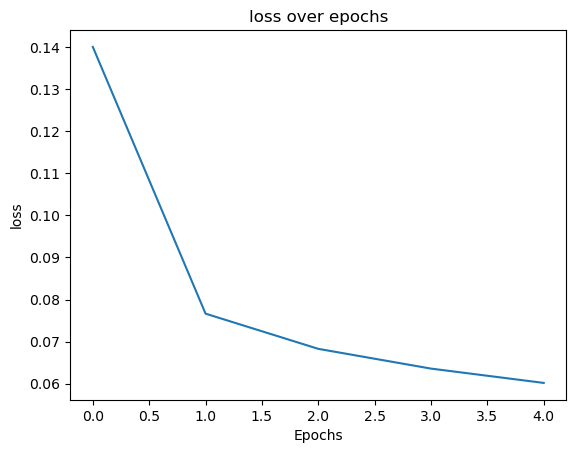

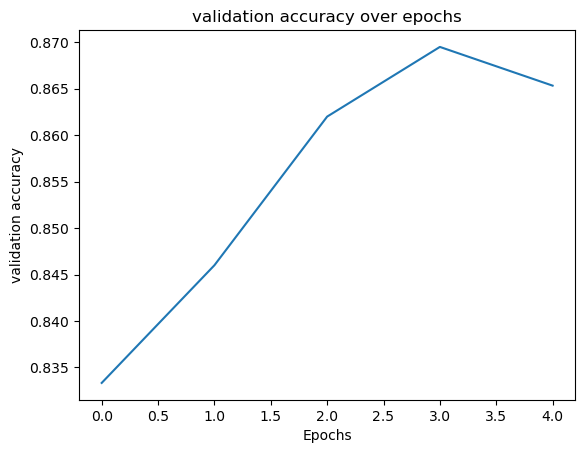

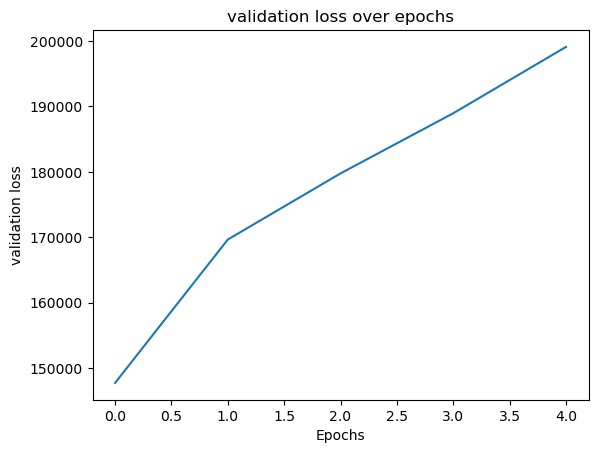

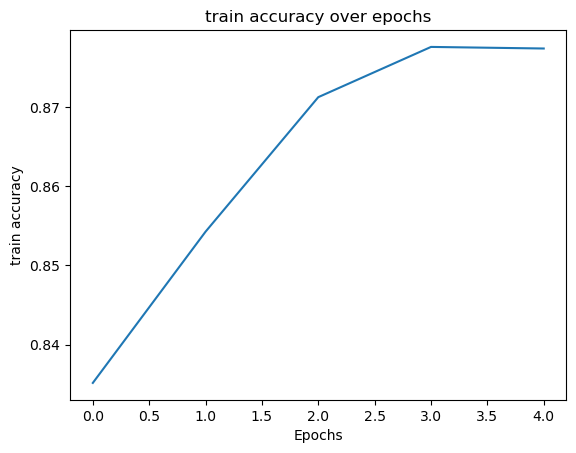

accuracy on unseen (test data): 0.8568


In [24]:
if __name__ == '__main__':
    #processing the data
    data = PreProc()
    
    #flatten the data and make it 0 mean
    train_x, test_x = data.flattenAndCentralize()
    trainx = train_x/255.0
    testx = test_x/255.0
    train_y, test_y = data.getLabels()
    
    #make a neural network
    neuralNet = FFNet(0, len(trainx[0]), 10)
    
    #add hidden layers
    neuralNet.addHiddenLayer(64, "xavier")
    neuralNet.addHiddenLayer(64, "xavier")
    neuralNet.addHiddenLayer(64, "xavier")
    
    #add output layer.
    neuralNet.addOutputLayer(10, "xavier")
    
    #compile the model
    neuralNet.solidify()
    
    #train the model
    weights,biases = neuralNet.fit("nadam",64, 0.001, "sigmoid", trainx, train_y, 0, 5)